In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
! pip install openpyxl

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19dataset/COVID-19 Dataset.xlsx
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 5.0 MB/s eta 0:00:00


> "!pip install openpyxl" in kaggle console for excel spreadsheet import to work

In [2]:
df = pd.read_excel("../input/covid19dataset/COVID-19 Dataset.xlsx", engine="openpyxl")

In [3]:
df.head()

,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,1,"Shenzhen, Guangdong",China,male,66.0,2020-01-03,2020-01-11 00:00:00,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8,1
1,2,Shanghai,China,female,56.0,2020-01-15,2020-01-15 00:00:00,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3,Zhejiang,China,male,46.0,2020-01-04,2020-01-17 00:00:00,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,13,0
3,4,Tianjin,China,female,60.0,NaT,NaN,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,5,Tianjin,China,male,58.0,NaT,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0


>Initial analysis.
>Possibility for duplicate strings in the location, country, and symptom1-6 columns through spelling mistakes or inconsistent capitalisation.

>Sym_on and hosp_vis can be disregarded as diff_sym_hos attribute measures number of days between the symptomatic date and the hospital admission date.

>Handle null values in symptom columns and elsewhere.

In [4]:
a = df['symptom1'].drop_duplicates().sort_values()
print (a)

410       chest discomfort
302                 chills
194                  cough
757      cough with sputum
230                fatigue
672                  feve\
193                  fever
485           flu symptoms
323               headache
398             high fever
289             joint pain
339                malaise
309             mild cough
363             mild fever
269                 nausea
510    physical discomfort
507                 reflux
724             runny nose
402              sore body
277            sore throat
330      throat discomfort
197            throat pain
575                  tired
219               vomiting
0                      NaN
Name: symptom1, dtype: object


>"feve\\" and "fever" need to be handled. 

>NaN values will be handled dataset wide later. 

>No other inconsistencies in this column.

In [5]:
a = df['symptom2'].drop_duplicates().sort_values()
print (a)

216           abdominal pain
398           aching muscles
250           breathlessness
495               chest pain
411                    chill
194                   chills
267                     cold
195                    cough
518                 coughing
219                 diarrhea
230     difficulty breathing
268                  fatigue
197                    fever
226                 headache
514             itchy throat
218               joint pain
220         loss of appetite
231                  malaise
487             muscle aches
248              muscle pain
683                  myalgia
279          nasal discharge
256                pneumonia
305     respiratory distress
205               runny nose
679      shortness of breath
310                   sneeze
249              sore throat
253                   sputum
334                   thirst
239                 vomiting
0                        NaN
Name: symptom2, dtype: object


>"chill" and "chills" need to be handled

>No other inconsistencies identified across the remaining columns

In [6]:
df['symptom1'].replace(to_replace=r'feve\\', value='fever', regex=True, inplace=True)
df['symptom2'].replace(to_replace=r'chills', value='chill', regex=True, inplace=True)

> Replace the duplicate strings

<AxesSubplot:xlabel='symptom1', ylabel='result'>

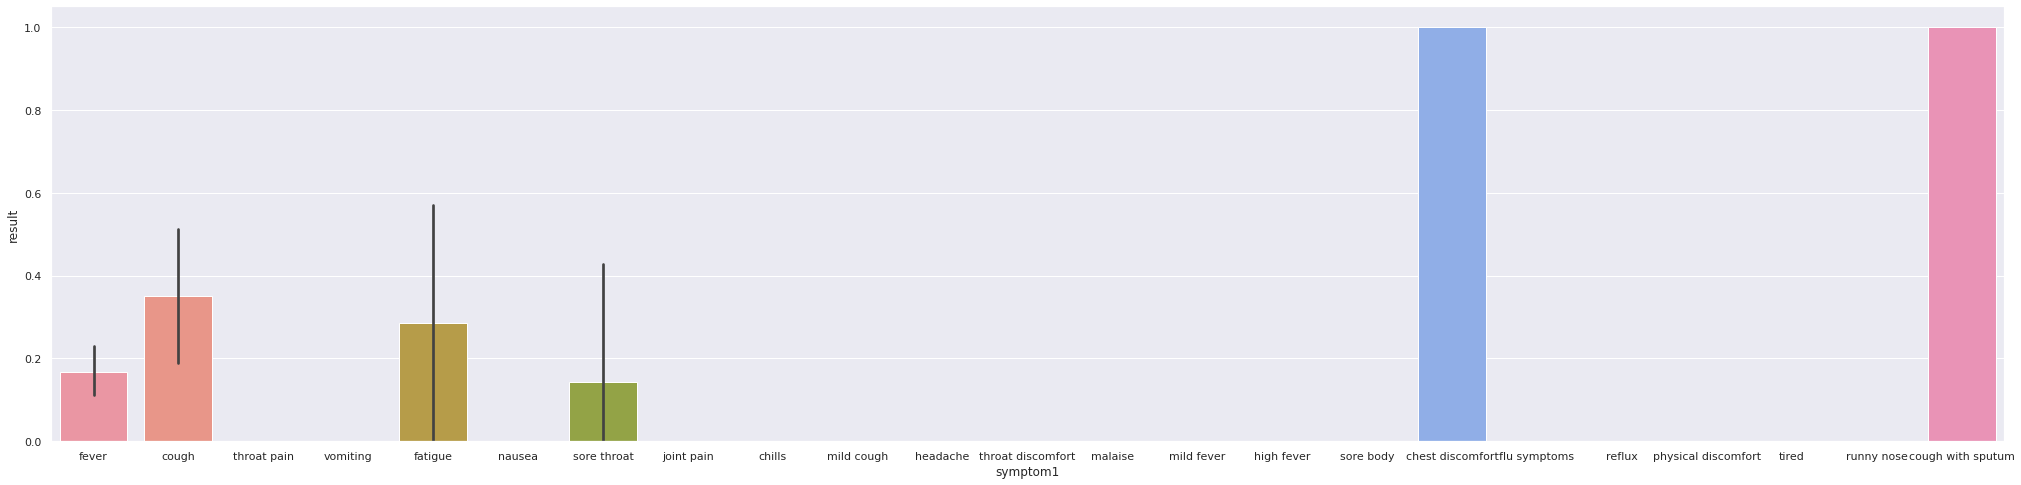

In [7]:
sns.set(rc = {'figure.figsize':(35,8)})
sns.barplot(x='symptom1', y='result', data=df)

>Initial analysis of symptom1 attribute

>Cough with Sputum as well as chest discomfort 100% liklihood of Covid positive

>Fever, cough, fatigue and sore throat also noteworthy.

In [8]:
df = df[df['age'].notna()] 
df = df[df['gender'].notna()] 

>Remove rows with null values that cant be replaced with zero

In [9]:
labelencoder = LabelEncoder()
df['location_Enc']=labelencoder.fit_transform(df['location'])
df['country_Enc']=labelencoder.fit_transform(df['country'])
df['gender_Enc']=labelencoder.fit_transform(df['gender'])
df['symptom1_Enc']=labelencoder.fit_transform(df['symptom1'])
df['symptom2_Enc']=labelencoder.fit_transform(df['symptom2'])
df['symptom3_Enc']=labelencoder.fit_transform(df['symptom3'])
df['symptom4_Enc']=labelencoder.fit_transform(df['symptom4'])
df['symptom5_Enc']=labelencoder.fit_transform(df['symptom5'])
df['symptom6_Enc']=labelencoder.fit_transform(df['symptom6'])

> Encode string characteristics in order to perform Logistic Regression

> Encoded attributes have _Enc suffix

In [10]:
df.drop('location', axis=1, inplace=True)
df.drop('country', axis=1, inplace=True)
df.drop('gender', axis=1, inplace=True)
df.drop('symptom1', axis=1, inplace=True)
df.drop('symptom2', axis=1, inplace=True)
df.drop('symptom3', axis=1, inplace=True)
df.drop('symptom4', axis=1, inplace=True)
df.drop('symptom5', axis=1, inplace=True)
df.drop('symptom6', axis=1, inplace=True)
df.drop('sym_on', axis=1, inplace=True)
df.drop('hosp_vis', axis=1, inplace=True)

> Drop the old columns that are now encoded, as well as sym_on and hosp_vis as diff_sym_hos already accounts for both these variables.

In [11]:
df.fillna(value=0, method=None, axis=1, inplace=True, limit=None, downcast=None)

> Replace null attributes with 0

In [12]:
df.isnull().values.any()

False

> Check if any null values remain

In [13]:
y = df['result']
x = df.drop('result', axis=1)

> Create the two datasets. y contains the results/whether or not a person tested positive or not. x contains all the columns minus the result column.


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

> Split datasets into test and train datasets.

> x_train and x_test have 80% of the data (training dataset). y_train and y_test have the other 20% (test dataset).

In [15]:
x_train.shape, y_train.shape

((499, 14), (499,))

> training dataset has 690 rows. x_train has 14 columns (attributes).

In [16]:
x_test.shape, y_test.shape

((125, 14), (125,))

> test dataset has 173 rows. x_test has 14 columns (attributes).

In [17]:
target = 'result'

> Assign 'target' / the value the model wants to predict

In [18]:
numerical_feature_columns = list(df._get_numeric_data().columns)
numerical_feature_columns

['id',
 'age',
 'vis_wuhan',
 'from_wuhan',
 'diff_sym_hos',
 'result',
 'location_Enc',
 'country_Enc',
 'gender_Enc',
 'symptom1_Enc',
 'symptom2_Enc',
 'symptom3_Enc',
 'symptom4_Enc',
 'symptom5_Enc',
 'symptom6_Enc']

[Text(0.5, 1.0, 'Attribute Heatmap')]

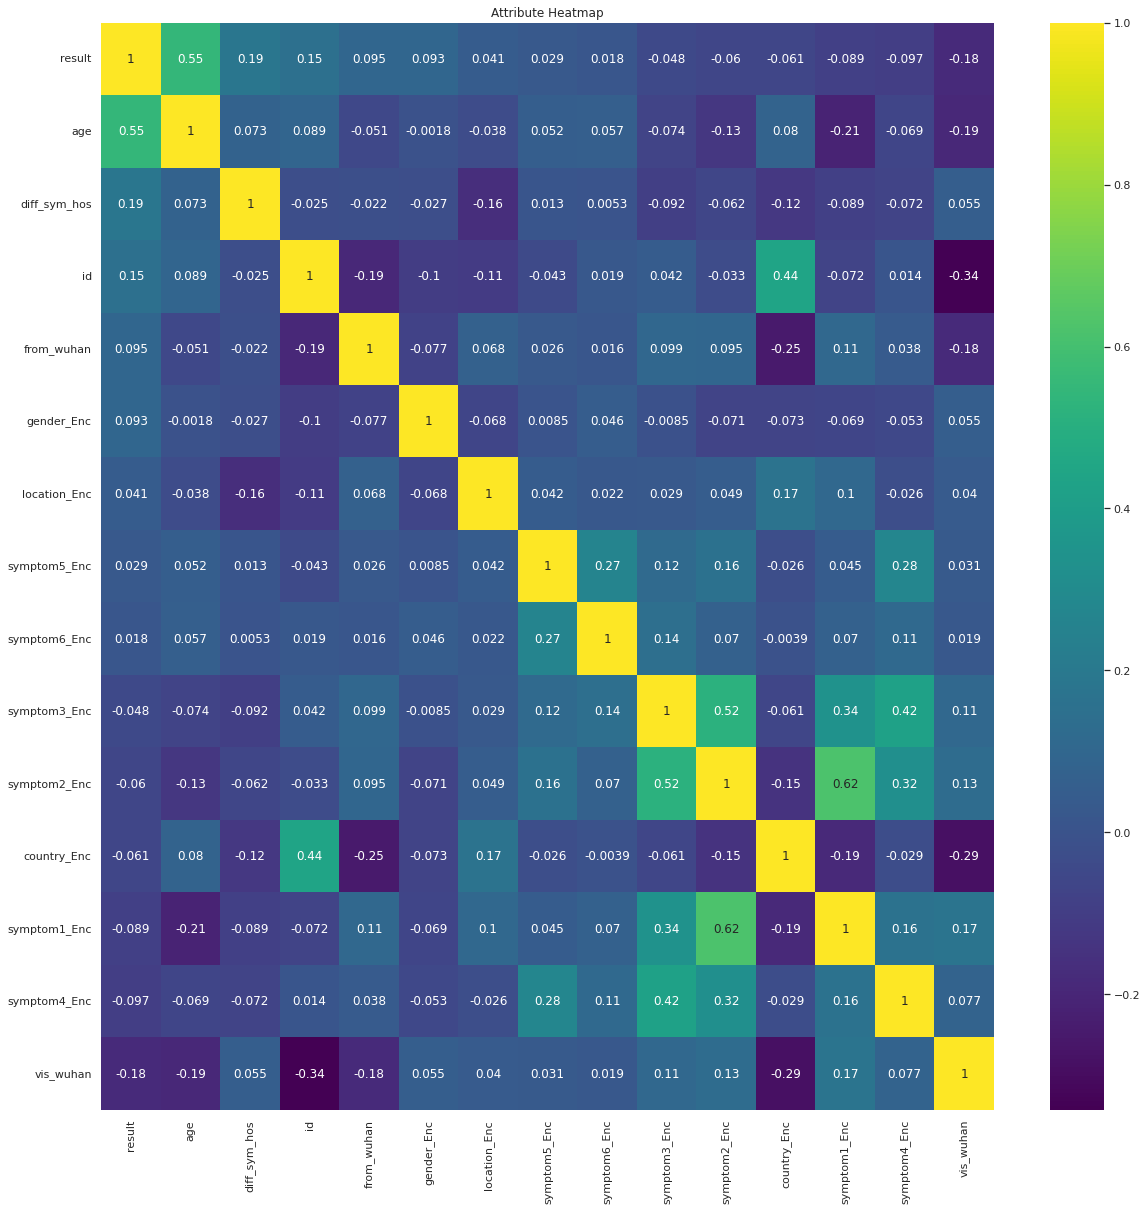

In [19]:
k = 15
cols = df[numerical_feature_columns].corr().nlargest(k, target)[target].index
cm = df[cols].corr()
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, cmap = "viridis").set(title='Attribute Heatmap')

> Heatmap calculates weightings for each attribute, higher weighting means high influence the attribute has on the result identification.

> From this I can identify that age and the symptom columns are most noteworthy.

In [20]:
clf_lr = LogisticRegression(max_iter = 5000)
lr_baseline_model = clf_lr.fit(x_train,y_train)

> Perform Logistic Regression

In [21]:
def generate_evaluation(model, x, y):
    print("Accuracy is:", accuracy_score(y,model.predict(x)))
    print("F1 score is:", f1_score(y,model.predict(x)))

>Generate Accuracy and F1 score function definition

In [22]:
generate_evaluation(lr_baseline_model, x_test, y_test)
baselineaccuracy = accuracy_score(y,lr_baseline_model.predict(x))
baselinef1 = f1_score(y,lr_baseline_model.predict(x))
baselinerecall = recall_score(y, lr_baseline_model.predict(x))
baselineprecision = precision_score(y, lr_baseline_model.predict(x))

Accuracy is: 0.976
F1 score is: 0.9142857142857143


> Generate accuracy and F1 score.

At time of run (no attribute selection):

>Accuracy is: 0.9710982658959537

>F1 score is: 0.8837209302325583

>

In [23]:
y_predicted = lr_baseline_model.predict(x_test)
confusion_matrix(y_test,y_predicted)

array([[106,   0],
       [  3,  16]])

At time of run (No attribute selection).
> 104 true negatives.

> 3 false positives.

> 2 false negatives.

> 16 true positives

In [24]:
df.head()

,id,age,vis_wuhan,from_wuhan,diff_sym_hos,result,location_Enc,country_Enc,gender_Enc,symptom1_Enc,symptom2_Enc,symptom3_Enc,symptom4_Enc,symptom5_Enc,symptom6_Enc
0,1,66.0,1,0.0,8,1,77,3,1,23,30,19,12,3,1
1,2,56.0,0,1.0,0,0,75,3,0,23,30,19,12,3,1
2,3,46.0,0,1.0,13,0,102,3,1,23,30,19,12,3,1
3,4,60.0,1,0.0,0,0,86,3,0,23,30,19,12,3,1
4,5,58.0,0,0.0,0,0,86,3,1,23,30,19,12,3,1


> No attribute selection dataset.

In [25]:
df.drop('vis_wuhan', axis=1, inplace=True)
df.drop('from_wuhan', axis=1, inplace=True)
df.drop('location_Enc', axis=1, inplace=True)
df.drop('country_Enc', axis=1, inplace=True)
df.drop('gender_Enc', axis=1, inplace=True)

> Drop lower weighting attributes identified by the heatmap prior

In [26]:
df.head()

,id,age,diff_sym_hos,result,symptom1_Enc,symptom2_Enc,symptom3_Enc,symptom4_Enc,symptom5_Enc,symptom6_Enc
0,1,66.0,8,1,23,30,19,12,3,1
1,2,56.0,0,0,23,30,19,12,3,1
2,3,46.0,13,0,23,30,19,12,3,1
3,4,60.0,0,0,23,30,19,12,3,1
4,5,58.0,0,0,23,30,19,12,3,1


> Dataset post attribute selection

In [27]:
y = df['result']
x = df.drop('result', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

> Re-split dataset into training and test

In [28]:
print("Training:", x_train.shape, y_train.shape)
print("Test:",x_test.shape, y_test.shape)

Training: (499, 9) (499,)
Test: (125, 9) (125,)


> Check dataset split

In [29]:
clf_lr = LogisticRegression(max_iter = 5000)
lr_selection_model = clf_lr.fit(x_train,y_train)

In [30]:
generate_evaluation(lr_selection_model, x_test, y_test)
logisticselectionaccuracy = accuracy_score(y,lr_selection_model.predict(x))
logisticselectionf1 = f1_score(y,lr_selection_model.predict(x))
logisticselectionrecall = recall_score(y, lr_selection_model.predict(x))
logisticselectionprecision = precision_score(y, lr_selection_model.predict(x))

Accuracy is: 0.896
F1 score is: 0.6285714285714286


In [31]:
confusion_matrix(y_test,y_predicted)

array([[97, 12],
       [12,  4]])

In [32]:
df = pd.read_excel("../input/covid19dataset/COVID-19 Dataset.xlsx", engine="openpyxl")
df['symptom1'].replace(to_replace=r'feve\\', value='fever', regex=True, inplace=True)
df['symptom2'].replace(to_replace=r'chills', value='chill', regex=True, inplace=True)
df = df[df['age'].notna()] 
df = df[df['gender'].notna()] 
labelencoder = LabelEncoder()
df['location_Enc']=labelencoder.fit_transform(df['location'])
df['country_Enc']=labelencoder.fit_transform(df['country'])
df['gender_Enc']=labelencoder.fit_transform(df['gender'])
df['symptom1_Enc']=labelencoder.fit_transform(df['symptom1'])
df['symptom2_Enc']=labelencoder.fit_transform(df['symptom2'])
df['symptom3_Enc']=labelencoder.fit_transform(df['symptom3'])
df['symptom4_Enc']=labelencoder.fit_transform(df['symptom4'])
df['symptom5_Enc']=labelencoder.fit_transform(df['symptom5'])
df['symptom6_Enc']=labelencoder.fit_transform(df['symptom6'])

In [33]:
df.drop('location', axis=1, inplace=True)
df.drop('country', axis=1, inplace=True)
df.drop('gender', axis=1, inplace=True)
df.drop('symptom1', axis=1, inplace=True)
df.drop('symptom2', axis=1, inplace=True)
df.drop('symptom3', axis=1, inplace=True)
df.drop('symptom4', axis=1, inplace=True)
df.drop('symptom5', axis=1, inplace=True)
df.drop('symptom6', axis=1, inplace=True)
df.drop('sym_on', axis=1, inplace=True)
df.drop('hosp_vis', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.fillna(value=0, method=None, axis=1, inplace=True, limit=None, downcast=None)

> Reset dataset to pre attribute selection state

In [34]:
df.head()

,age,vis_wuhan,from_wuhan,diff_sym_hos,result,location_Enc,country_Enc,gender_Enc,symptom1_Enc,symptom2_Enc,symptom3_Enc,symptom4_Enc,symptom5_Enc,symptom6_Enc
0,66.0,1,0.0,8,1,77,3,1,23,30,19,12,3,1
1,56.0,0,1.0,0,0,75,3,0,23,30,19,12,3,1
2,46.0,0,1.0,13,0,102,3,1,23,30,19,12,3,1
3,60.0,1,0.0,0,0,86,3,0,23,30,19,12,3,1
4,58.0,0,0.0,0,0,86,3,1,23,30,19,12,3,1


In [35]:
y = df['result']
x = df.drop('result', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

>Data set splitting

In [36]:
dectreemodel = DecisionTreeClassifier(max_leaf_nodes=10,random_state=0)
dectreemodel.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)

> Decision Tree Classifier

In [37]:
y_predicted = dectreemodel.predict(x_test)

In [38]:
print("Accuracy:", accuracy_score(y_test,y_predicted))
confusion_matrix(y_test,y_predicted)
decisiontreeaccuracy = accuracy_score(y,dectreemodel.predict(x))
decisiontreef1 = f1_score(y,dectreemodel.predict(x))
decisiontreerecall = recall_score(y, dectreemodel.predict(x))
decisiontreeprecision = precision_score(y, dectreemodel.predict(x))

Accuracy: 0.944


>Generate evaluation metrics

In [39]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()
randomforest.fit(x_train,y_train)
y_predict = randomforest.predict(x_test)

> Random Forest classifier

In [40]:
print (confusion_matrix(y_test,y_predict))
randomforestaccuracy = accuracy_score(y,randomforest.predict(x))
randomforestf1 = f1_score(y,randomforest.predict(x))
randomforestrecall = recall_score(y, randomforest.predict(x))
randomforestprecision = precision_score(y, randomforest.predict(x))

[[101   4]
 [  1  19]]


>Generate evaluation metrics

> Graph generation

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Performance')

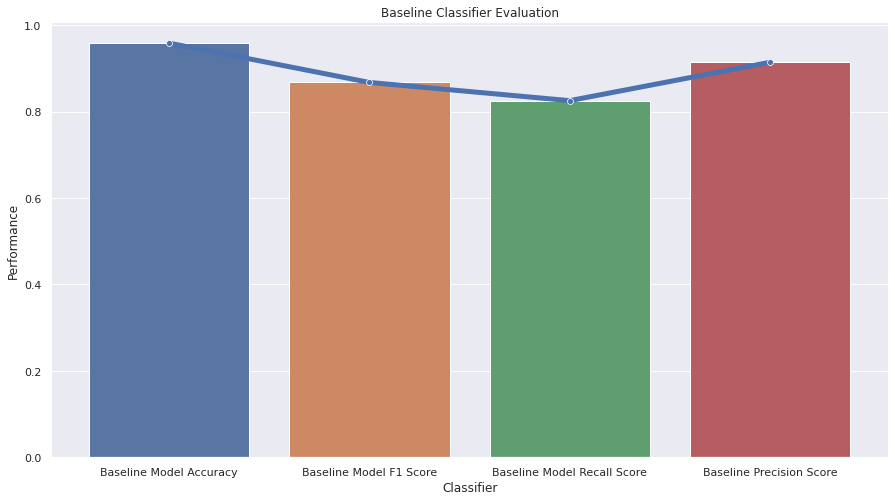

In [41]:
sns.set(rc = {'figure.figsize':(15,8)})
x = ["Baseline Model Accuracy","Baseline Model F1 Score","Baseline Model Recall Score","Baseline Precision Score"]
y = [baselineaccuracy,baselinef1,baselinerecall,baselineprecision]
ax = sns.barplot(x,y)
sns.lineplot(x,y,marker='o',linewidth = 5)
ax.set(title='Baseline Classifier Evaluation')
ax.set_xlabel("Classifier")
ax.set_ylabel("Performance")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 1.0)

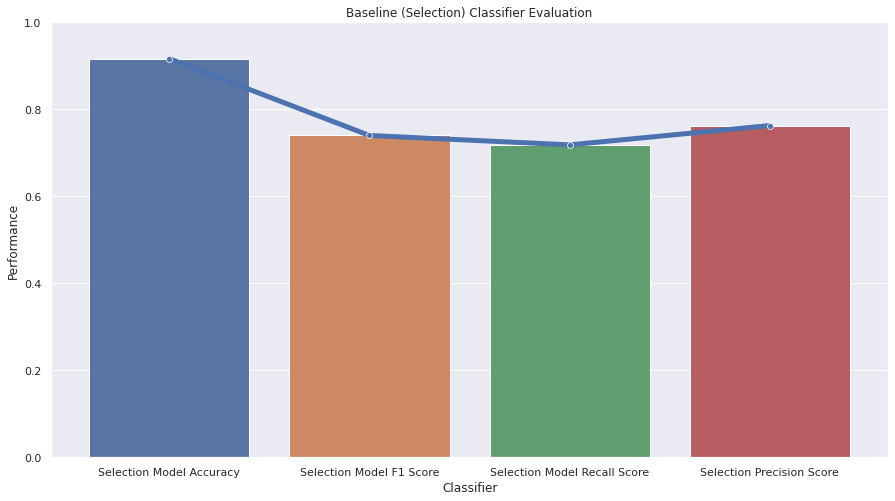

In [42]:
sns.set(rc = {'figure.figsize':(15,8)})
x = ["Selection Model Accuracy","Selection Model F1 Score","Selection Model Recall Score","Selection Precision Score"]
y = [logisticselectionaccuracy,logisticselectionf1,logisticselectionrecall,logisticselectionprecision]
ax = sns.barplot(x,y)
sns.lineplot(x,y,marker='o',linewidth = 5)
ax.set(title='Baseline (Selection) Classifier Evaluation')
ax.set_xlabel("Classifier")
ax.set_ylabel("Performance")
ax.set_ylim(0,1)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Performance')

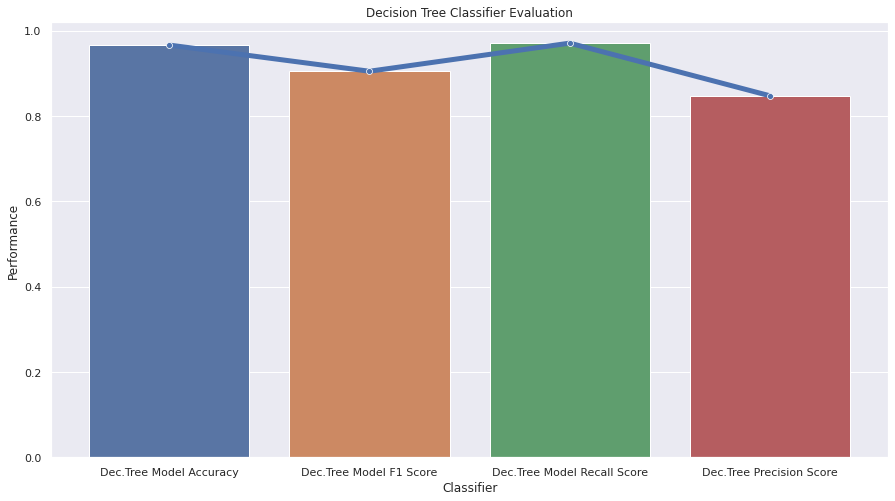

In [43]:
sns.set(rc = {'figure.figsize':(15,8)})
x = ["Dec.Tree Model Accuracy","Dec.Tree Model F1 Score","Dec.Tree Model Recall Score","Dec.Tree Precision Score"]
y = [decisiontreeaccuracy,decisiontreef1,decisiontreerecall,decisiontreeprecision]
ax = sns.barplot(x,y)
sns.lineplot(x,y,marker='o',linewidth = 5)
ax.set(title='Decision Tree Classifier Evaluation')
ax.set_xlabel("Classifier")
ax.set_ylabel("Performance")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Performance')

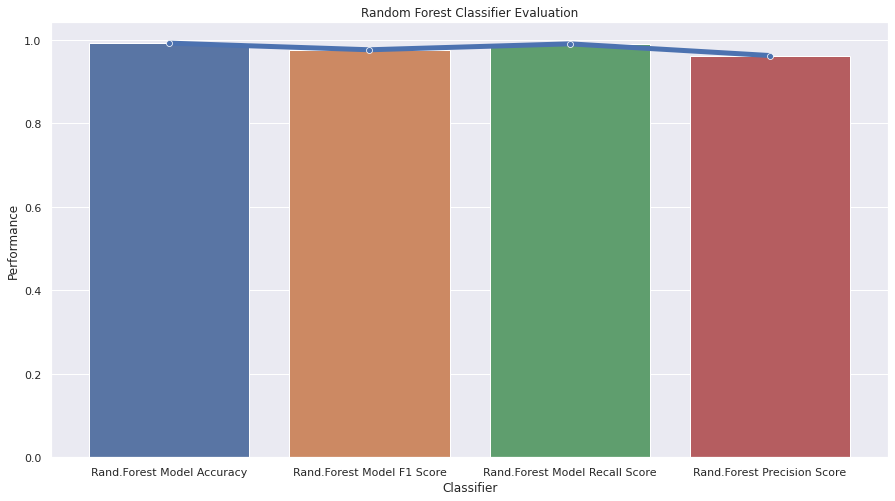

In [44]:
sns.set(rc = {'figure.figsize':(15,8)})
x = ["Rand.Forest Model Accuracy","Rand.Forest Model F1 Score","Rand.Forest Model Recall Score","Rand.Forest Precision Score"]
y = [randomforestaccuracy,randomforestf1,randomforestrecall,randomforestprecision]
ax = sns.barplot(x,y)
sns.lineplot(x,y,marker='o',linewidth = 5)
ax.set(title='Random Forest Classifier Evaluation')
ax.set_xlabel("Classifier")
ax.set_ylabel("Performance")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Performance')

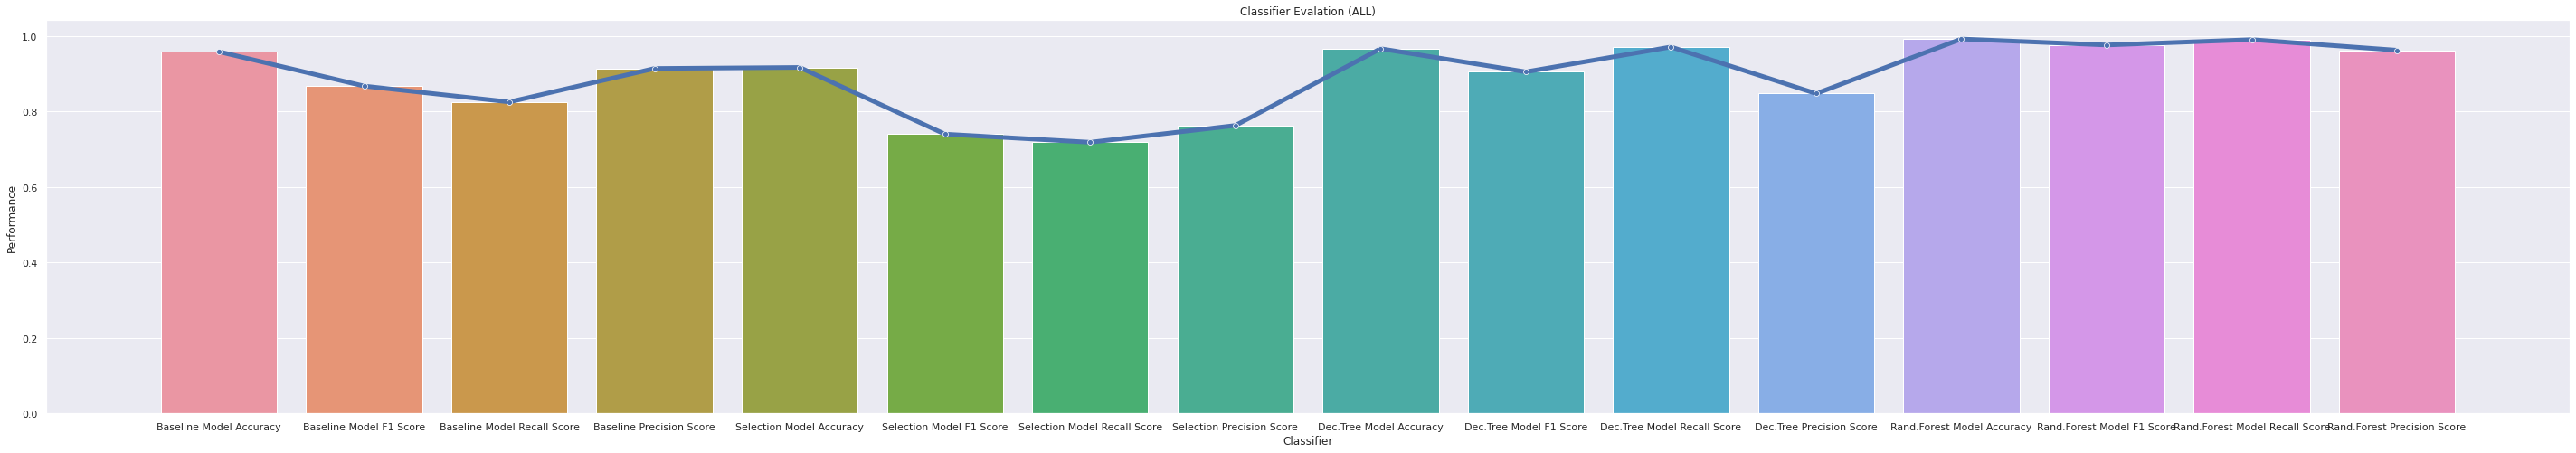

In [45]:
sns.set(rc = {'figure.figsize':(50,8)})
x = ["Baseline Model Accuracy","Baseline Model F1 Score","Baseline Model Recall Score","Baseline Precision Score",
    "Selection Model Accuracy","Selection Model F1 Score","Selection Model Recall Score","Selection Precision Score",
    "Dec.Tree Model Accuracy","Dec.Tree Model F1 Score","Dec.Tree Model Recall Score","Dec.Tree Precision Score",
    "Rand.Forest Model Accuracy","Rand.Forest Model F1 Score","Rand.Forest Model Recall Score","Rand.Forest Precision Score"]
y = [baselineaccuracy,baselinef1,baselinerecall,baselineprecision,
    logisticselectionaccuracy,logisticselectionf1,logisticselectionrecall,logisticselectionprecision,
    decisiontreeaccuracy,decisiontreef1,decisiontreerecall,decisiontreeprecision,
    randomforestaccuracy,randomforestf1,randomforestrecall,randomforestprecision]
ax = sns.barplot(x,y)
sns.lineplot(x,y,marker='o',linewidth = 5)
ax.set(title='Classifier Evalation (ALL)')
ax.set_xlabel("Classifier")
ax.set_ylabel("Performance")

In [46]:
d = {'Accuracy': [baselineaccuracy, logisticselectionaccuracy, decisiontreeaccuracy, randomforestaccuracy],
     'F1 Score':[baselinef1, logisticselectionf1, decisiontreef1, randomforestf1],
     'Recall': [baselinerecall, logisticselectionf1, decisiontreef1, randomforestf1],
     'Precision':[baselineprecision, logisticselectionprecision, decisiontreeprecision, randomforestprecision]}
classeval = pd.DataFrame(data=d)
classeval.index=["Baseline","Selection","Decision Tree","Random Forest"]
#classeval = classeval.iloc[::-1]

In [47]:
#classeval.head()

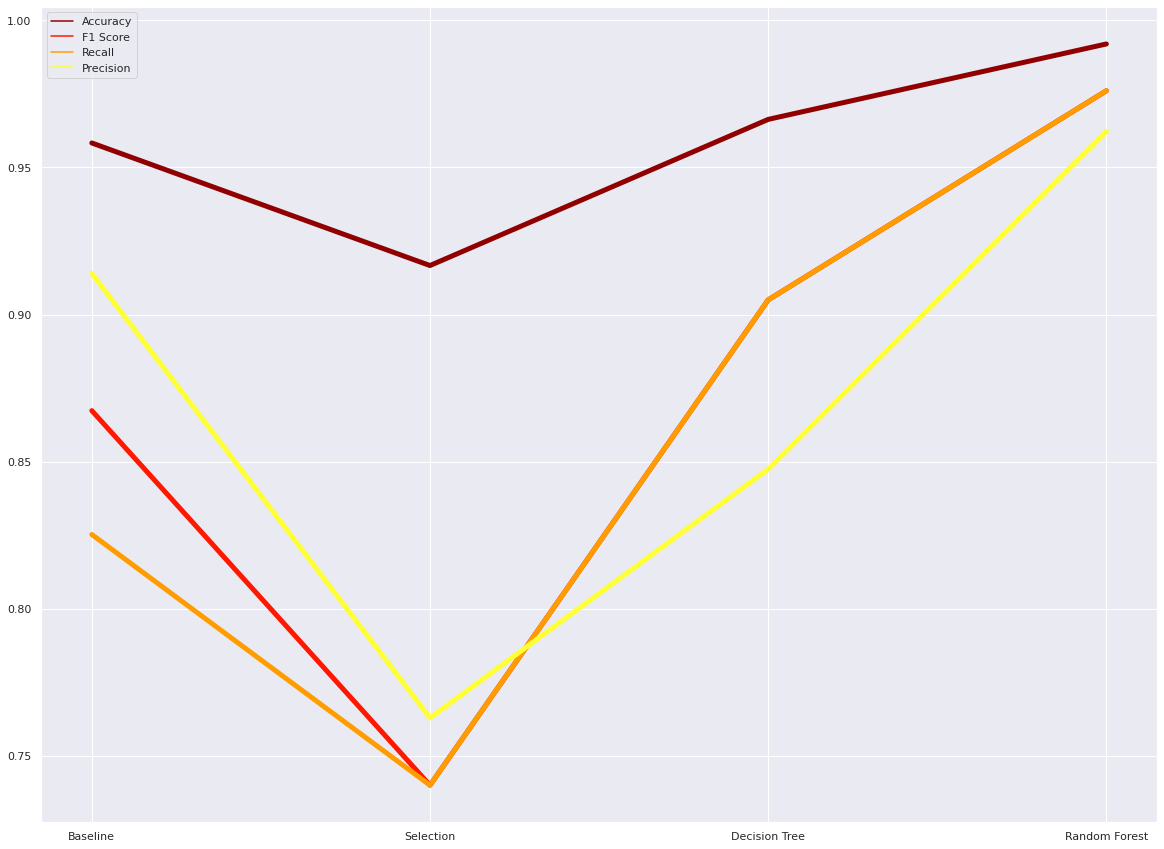

In [48]:
#ax = sns.scatterplot(data=classeval,s=200, legend=0, x='Classifier')
sns.set(rc = {'figure.figsize':(20,15)})
ax = sns.lineplot(data=classeval, linewidth = 5,palette = 'hot', dashes= False)
#ax.set(title='Classifier Evalation (ALL)')

In [49]:
classeval.head()

,Accuracy,F1 Score,Recall,Precision
Baseline,0.958333,0.867347,0.825243,0.913978
Selection,0.916667,0.740000,0.740000,0.762887
Decision Tree,0.966346,0.904977,0.904977,0.847458
Random Forest,0.991987,0.976077,0.976077,0.962264
